In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [33]:
def log_multivariate_normal(X, mean, cov):
    d = X.shape[1]
    cov += np.eye(d) * 1e-6 
    sign, logdet = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    diff = X - mean
    return -0.5 * (d * np.log(2 * np.pi) + logdet + np.sum(diff @ inv_cov * diff, axis=1))

In [34]:
class GMM:
    def __init__(self, n_components, covariance_type='full', max_iter=100, tol=1e-4):
        self.K = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.tol = tol

    def _initialize(self, X):
        N, D = X.shape
        self.pi = np.ones(self.K) / self.K
        self.mu = X[np.random.choice(N, self.K, replace=False)]

        if self.covariance_type == 'tied':
            self.cov = np.cov(X.T) + np.eye(D) * 1e-6
        elif self.covariance_type == 'diagonal':
            var = np.var(X, axis=0)
            self.cov = np.array([np.maximum(var, 1e-6) for _ in range(self.K)])
        elif self.covariance_type == 'spherical':
            var = np.mean(np.var(X, axis=0))
            self.cov = np.array([max(var, 1e-6) for _ in range(self.K)])
        else:  # full
            cov_matrix = np.cov(X.T) + np.eye(D) * 1e-6
            self.cov = np.array([cov_matrix for _ in range(self.K)])

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            if self.covariance_type == 'spherical':
                cov = np.eye(D) * self.cov[k]
            elif self.covariance_type == 'diagonal':
                cov = np.diag(self.cov[k])
            elif self.covariance_type == 'tied':
                cov = self.cov
            else:  # full
                cov = self.cov[k]
            log_resp[:, k] = np.log(self.pi[k]) + log_multivariate_normal(X, self.mu[k], cov)
        log_sum = np.logaddexp.reduce(log_resp, axis=1)
        self.log_likelihood = np.sum(log_sum)
        resp = np.exp(log_resp - log_sum[:, None])
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N
        self.mu = (resp.T @ X) / Nk[:, None]

        if self.covariance_type == 'tied':
            cov = np.zeros((D, D))
            for k in range(self.K):
                diff = X - self.mu[k]
                cov += (resp[:, k][:, None] * diff).T @ diff
            self.cov = cov / N + np.eye(D) * 1e-6

        elif self.covariance_type == 'full':
            covs = []
            for k in range(self.K):
                diff = X - self.mu[k]
                weighted = resp[:, k][:, None] * diff
                cov = (weighted.T @ diff) / Nk[k] + np.eye(D) * 1e-6
                covs.append(cov)
            self.cov = np.array(covs)

        elif self.covariance_type == 'diagonal':
            covs = []
            for k in range(self.K):
                diff = X - self.mu[k]
                weighted = resp[:, k][:, None] * diff
                var = np.sum(weighted * diff, axis=0) / Nk[k]  # (D,)
                var = np.maximum(var, 1e-6)
                covs.append(var)
            self.cov = np.array(covs)  # shape (K,D), keep as vector

        elif self.covariance_type == 'spherical':
            covs = []
            for k in range(self.K):
                diff = X - self.mu[k]
                weighted = resp[:, k][:, None] * diff
                var = np.trace((weighted.T @ diff) / Nk[k]) / X.shape[1]  # scalar
                var = max(var, 1e-6)
                covs.append(var)
            self.cov = np.array(covs)  # shape (K,), keep as scalar


    def fit(self, X):
        self._initialize(X)
        prev_ll = None
        for i in range(self.max_iter):
            resp = self._e_step(X)
            self._m_step(X, resp)
            if prev_ll is not None and abs(self.log_likelihood - prev_ll) < self.tol:
                print(f"Converged at iteration {i}")
                break
            prev_ll = self.log_likelihood

    def predict(self, X):
        resp = self._e_step(X)
        return np.argmax(resp, axis=1)


In [35]:
data = load_breast_cancer()
X = data.data
y_true = data.target
X_scaled = StandardScaler().fit_transform(X)

In [36]:
def map_clusters_to_labels(y_true, y_cluster):
    y_pred = np.zeros_like(y_cluster)
    for c in np.unique(y_cluster):
        mask = (y_cluster == c)
        y_pred[mask] = np.bincount(y_true[mask]).argmax()
    return y_pred

In [37]:
covariance_types = ['full', 'tied', 'diagonal', 'spherical']
results = []

for cov_type in covariance_types:
    print(f"\nRunning GMM with covariance type: {cov_type}")
    gmm = GMM(n_components=2, covariance_type=cov_type, max_iter=200, tol=1e-4)
    gmm.fit(X_scaled)
    clusters = gmm.predict(X_scaled)
    y_pred = map_clusters_to_labels(y_true, clusters)
    ari = adjusted_rand_score(y_true, clusters)
    nmi = normalized_mutual_info_score(y_true, clusters)
    acc = np.mean(y_pred == y_true)
    results.append([cov_type, gmm.log_likelihood, acc, ari, nmi])

print("\n===== GMM Covariance Comparison =====")
print(f"{'Covariance':<12} {'LogLik':>12} {'Acc':>8} {'ARI':>8} {'NMI':>8}")
for r in results:
    print(f"{r[0]:<12} {r[1]:>12.2f} {r[2]:>8.3f} {r[3]:>8.3f} {r[4]:>8.3f}")


Running GMM with covariance type: full
Converged at iteration 3

Running GMM with covariance type: tied
Converged at iteration 20

Running GMM with covariance type: diagonal
Converged at iteration 17

Running GMM with covariance type: spherical
Converged at iteration 20

===== GMM Covariance Comparison =====
Covariance         LogLik      Acc      ARI      NMI
full             -3400.86    0.634    0.010    0.020
tied             -3894.39    0.671    0.067    0.107
diagonal        -18554.59    0.912    0.678    0.560
spherical       -20080.82    0.870    0.546    0.430


In [38]:
cov_types = [r[0] for r in results]
log_likelihoods = [r[1] for r in results]
accuracies = [r[2] for r in results]
aris = [r[3] for r in results]
nmis = [r[4] for r in results]

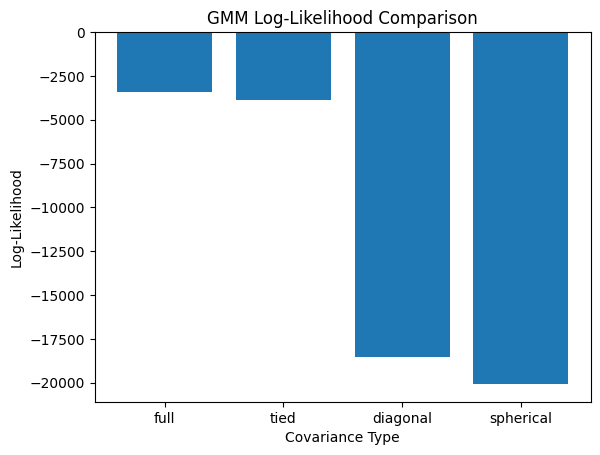

In [39]:
plt.figure()
plt.bar(covariance_types, log_likelihoods)
plt.xlabel("Covariance Type")
plt.ylabel("Log-Likelihood")
plt.title("GMM Log-Likelihood Comparison")
plt.show()


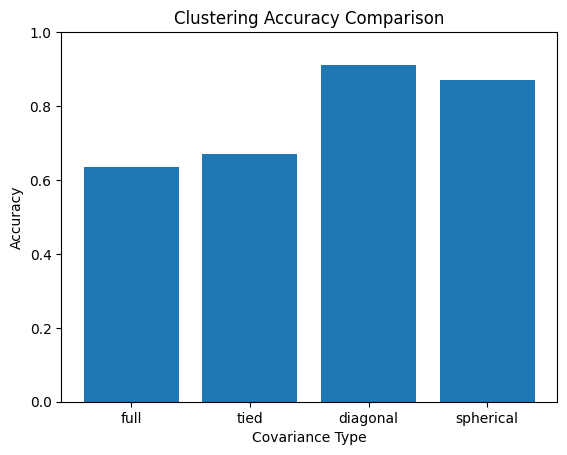

In [40]:
plt.figure()
plt.bar(covariance_types, accuracies)
plt.xlabel("Covariance Type")
plt.ylabel("Accuracy")
plt.title("Clustering Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


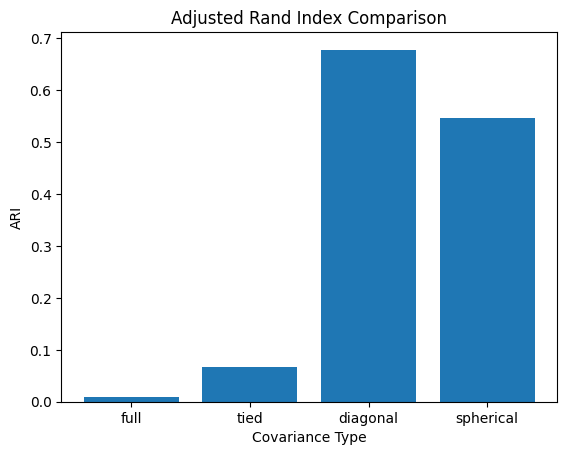

In [41]:
plt.figure()
plt.bar(covariance_types, aris)
plt.xlabel("Covariance Type")
plt.ylabel("ARI")
plt.title("Adjusted Rand Index Comparison")
plt.show()


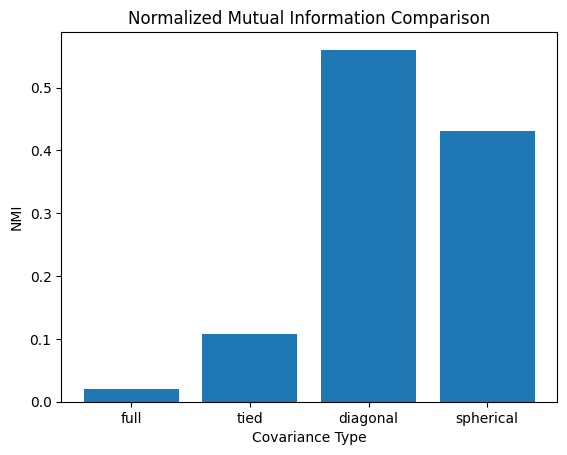

In [42]:
plt.figure()
plt.bar(covariance_types, nmis)
plt.xlabel("Covariance Type")
plt.ylabel("NMI")
plt.title("Normalized Mutual Information Comparison")
plt.show()
